# MLL23: A large publicly available single-cell peripheral blood dataset for domain generalized hematological disease diagnostics

## Getting started

1) Download the MLL23 dataset from Zenodo
2) Install the required packages

## Requirements

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import ntpath
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread
from tqdm import tqdm
import sklearn
from sklearn.cluster import AgglomerativeClustering

## Functions

In [2]:
def compute_mean(dataframe, selected_channels=[0,1,2], crop_size=None):
    '''
    this function computes the mean values of the color channels 
    of the (cropped) images specified in a dataframe 
    and adds the information to the dataframe
    '''
    for idx in tqdm(range(len(dataframe)), position=0, leave=True):
        if crop_size is None:
            #if no crop size is specified, the mean values for the whole image are computed
            h5_file_path = dataframe.loc[idx,"file"]
            try:
                image = plt.imread(h5_file_path)[:,:,selected_channels]
            except ValueError: 
                print(h5_file_path)
                break
            dataframe.loc[idx, 'mean1']= np.mean(image[:,:,0]) #red channel
            dataframe.loc[idx, 'mean2']= np.mean(image[:,:,1]) #green channel
            dataframe.loc[idx, 'mean3']= np.mean(image[:,:,2]) #blue channel
        else:
            #if a crop size is specified, the mean values for the cropped image are computed
            h5_file_path = dataframe.loc[idx,"file"]
            try:
                image = plt.imread(h5_file_path)[:,:,selected_channels]
                h1 = (image.shape[0] - crop_size) /2
                h1 = int(h1)
                h2 = (image.shape[0] + crop_size) /2
                h2 = int(h2)

                w1 = (image.shape[1] - crop_size) /2
                w1 = int(w1)
                w2 = (image.shape[1] + crop_size) /2
                w2 = int(w2)
                cropped_image = image[h1:h2,w1:w2, :]
            except ValueError: 
                print(h5_file_path)
                break
            dataframe.loc[idx, 'mean1']= np.mean(cropped_image[:,:,0]) #red channel
            dataframe.loc[idx, 'mean2']= np.mean(cropped_image[:,:,1]) #green channel
            dataframe.loc[idx, 'mean3']= np.mean(cropped_image[:,:,2]) #blue channel
            
    return dataframe


def crop(image, crop_size):
    #this funtions shows and returns the cropped version of an image
    h1 = (image.shape[0] - crop_size) /2
    h1 = int(h1)
    h2 = (image.shape[0] + crop_size) /2
    h2 = int(h2)

    w1 = (image.shape[1] - crop_size) /2
    w1 = int(w1)
    w2 = (image.shape[1] + crop_size) /2
    w2 = int(w2)
    cropped_image = image[h1:h2,w1:w2, :]
    plt.imshow(cropped_image)
    
    return cropped_image


def data_plot(dataframes,
                labels=['Acevedo20', 'Matek19', 'MLL23'],
                colors1=['lightblue', 'orange', 'greenyellow'],
                colors2=['darkblue', 'red', 'limegreen'],
                ):
    #this function plots the mean values and standartdeviations of the images in a dataframe
    f, axarr = plt.subplots(1,3, figsize=(15,5))
    df=0
    while df<len(dataframes):
        
        dataframe = dataframes[df]
        label=labels[df]
        color1=colors1[df]
        color2=colors2[df]

        x1=np.array(dataframe['mean1'])
        x2=np.array(dataframe['mean2'])
        x3=np.array(dataframe['mean3'])
        mean1=np.mean(np.array(dataframe['mean1']))
        mean2=np.mean(np.array(dataframe['mean2']))
        mean3=np.mean(np.array(dataframe['mean3']))
        std1=np.std(np.array(dataframe['mean1']))
        std2=np.std(np.array(dataframe['mean2']))
        std3=np.std(np.array(dataframe['mean3']))
        
        # red vs green channel
        
        axarr[0].set_xlabel("red")
        axarr[0].set_ylabel("green")

        a=np.array((x1,x2)).T

        axarr[0].scatter(a[:, 0], a[:, 1], s=3, color=color1, alpha=1)
        axarr[0].scatter(x=mean1, y=mean2, s=1, color=color2)
        axarr[0].plot([mean1-std1, mean1+std1],[mean2, mean2], color=color2, label=label)
        axarr[0].plot([mean1, mean1],[mean2-std2, mean2+std2], color=color2)


        # red vs blue channel

        axarr[1].set_xlabel("red")
        axarr[1].set_ylabel("blue")

        b=np.array((x1,x3)).T

        axarr[1].scatter(b[:, 0], b[:, 1], s=3, color=color1, alpha=1)
        axarr[1].scatter(x=mean1, y=mean3, s=1, color=color2)
        axarr[1].plot([mean1-std1, mean1+std1],[mean3, mean3], color=color2, label=label)
        axarr[1].plot([mean1, mean1],[mean3-std3, mean3+std3], color=color2)


        # green vs blue channel

        axarr[2].set_xlabel("green")
        axarr[2].set_ylabel("blue")

        b=np.array((x2,x3)).T

        axarr[2].scatter(b[:, 0], b[:, 1], s=3, color=color1, alpha=1)
        axarr[2].scatter(x=mean1, y=mean3, s=1, color=color2)
        axarr[2].plot([mean2-std2, mean2+std2],[mean3, mean3], color=color2, label=label)
        axarr[2].plot([mean2, mean2],[mean3-std3, mean3+std3], color=color2)

        plt.legend()

        f.tight_layout()

        df+=1


def data_report(dataframe):
    #this function presents information about the total number of images and the number of images per class in a dataframe
   print('\033[1m' + 'label \t \t \t#images'+ '\033[0m')
   print('')
   
   print(dataframe.label.value_counts())
   print('total' + '\t \t \t \t' + f'{len(dataframe)}')


def data_sample(dataframe, crop_size=None):
    #this function shows and returns a random image from a dataframe
    n=random.randint(0, len(dataframe)-1)
    image = mpimg.imread(dataframe.file[n])
    if crop_size is None:
        plt.title(f'label: {dataframe.label[n]}, dataset: {dataframe.dataset[n]}')
        plt.imshow(image)
    return image


def data_separation(dataframe, label):
    '''
    this function separates the data in a dataframe into two subsets 
    using the AgglomerativeClustering algorithm,
    plots the result 
    and returns the two subsets
    '''

    #compute mean values and standard deviations

    x1=np.array(dataframe['mean1'])
    x2=np.array(dataframe['mean2'])
    x3=np.array(dataframe['mean3'])
    mean1=np.mean(np.array(dataframe['mean1']))
    mean2=np.mean(np.array(dataframe['mean2']))
    mean3=np.mean(np.array(dataframe['mean3']))
    std1=np.std(np.array(dataframe['mean1']))
    std2=np.std(np.array(dataframe['mean2']))
    std3=np.std(np.array(dataframe['mean3']))

    #plot graphs

    plt.title(label)
    plt.xlabel('Red')
    plt.ylabel('Blue')

    c=np.array((x1,x3)).T
    clustering = AgglomerativeClustering(linkage='average').fit_predict(c)
    plt.scatter(c[:, 0], c[:, 1], c=clustering, s=3)
    subset1 = dataframe.copy()
    subset2 = dataframe.copy()
    subset1 = subset1.loc[clustering==0].reset_index(drop = True)
    subset2 = subset2.loc[clustering==1].reset_index(drop = True)

    return subset1, subset2


def finding_classes(data_dir, labels_dict):
    '''
    this function finds the folders in the root path and considers them
    as classes
    '''
    if labels_dict is None:
        classes = [folder for folder in sorted(os.listdir(data_dir)) if not folder.startswith('.') and not folder.startswith('_')]
    else:
        classes = [folder for folder in sorted(os.listdir(data_dir)) if not folder.startswith('.') and not folder.startswith('_')
                and not labels_dict[folder]==0]
    return classes


def metadata_generator(data_path, ds, labels_dict):
    #this function generates a dataframe containing image information (paths, labels, dataset)
    metadata = pd.DataFrame(columns=["image", "file", "label", "dataset"])
    list_of_classes = finding_classes(data_path, labels_dict)
    for cl in list_of_classes:
        metadata_dummy = pd.DataFrame(columns=["image", "file", "label", "dataset"])
        metadata_dummy["image"] = None
        metadata_dummy["file"] = sorted(glob(os.path.join(data_path, cl, "*")))
        if labels_dict is None:
            metadata_dummy["label"] = cl
        else:
            metadata_dummy["label"] = labels_dict[cl]
        metadata_dummy["dataset"] = ds
        for i in range(len(metadata_dummy)):
            metadata_dummy['image'].loc[i]=ntpath.basename(metadata_dummy['file'][i])
        metadata=pd.concat([metadata, metadata_dummy], ignore_index=True)
        metadata_dummy = None
        
    return metadata

## MLL23

The MLL23 dataset consists of 41,621 images of single nucleated cells. Each image has a size of 288 x 288 pixels and 25μm x 25μm, corresponding to a resolution of 11.52 pixels per μm.

### Description

The MLL23 dataset is a fully labeled peripheral blood single-cell dataset for detecting hematological diseases like acute myeloid leukemia. 
The data acquisition process was performed by the Munich Leukemia Laboratory. The resulting 41,621 images of single nucleated cells comprise 288 x 288 pixels and 25μm x 25μm, corresponding to a resolution of 11.52 pixels per μm. 
Next, five human expert examiners at the Munich Leukemia Laboratory annotated the images, assigning each single cell to one out of 18 classes.

### Preparation

First, the MLL23 dataset path has to be specified:

In [10]:
#set this path to the MLL23 dataset folder
MLL23_path='MLL23_dataset'

Then, the dataset needs to be loaded as a dataframe and can then be further analysed:

In [11]:
#generate a dataframe containing information for each image in the MLL23 dataset
MLL23_metadata = metadata_generator(MLL23_path, ds="MLL23", labels_dict=None) 

#show the dataframe
MLL23_metadata

,image,file,label,dataset
0,basophil_0001.TIF,MLL23_dataset/basophil/basophil_0001.TIF,basophil,MLL23
1,basophil_0002.TIF,MLL23_dataset/basophil/basophil_0002.TIF,basophil,MLL23
2,basophil_0003.TIF,MLL23_dataset/basophil/basophil_0003.TIF,basophil,MLL23
3,basophil_0004.TIF,MLL23_dataset/basophil/basophil_0004.TIF,basophil,MLL23
4,basophil_0005.TIF,MLL23_dataset/basophil/basophil_0005.TIF,basophil,MLL23
...,...,...,...,...
41616,smudge_cell_0984.TIF,MLL23_dataset/smudge_cell/smudge_cell_0984.TIF,smudge_cell,MLL23
41617,smudge_cell_0985.TIF,MLL23_dataset/smudge_cell/smudge_cell_0985.TIF,smudge_cell,MLL23
41618,smudge_cell_0986.TIF,MLL23_dataset/smudge_cell/smudge_cell_0986.TIF,smudge_cell,MLL23
41619,smudge_cell_0987.TIF,MLL23_dataset/smudge_cell/smudge_cell_0987.TIF,smudge_cell,MLL23


The MLL23 dataset contains the following 18 classes:

In [12]:
#show total number of images and number of images per class
data_report(MLL23_metadata)

label 	 	 	#images

label
myeloblast                   8606
neutrophil_segmented         7170
lymphocyte                   5532
hairy_cell                   3265
monocyte                     2510
eosinophil                   2448
normoblast                   2071
promyelocyte_atypical        2033
lymphocyte_large_granular    1849
plasma_cell                  1658
smudge_cell                   988
myelocyte                     747
promyelocyte                  745
neutrophil_band               687
basophil                      616
metamyelocyte                 483
lymphocyte_neoplastic         180
lymphocyte_reactive            33
Name: count, dtype: int64
total	 	 	 	41621


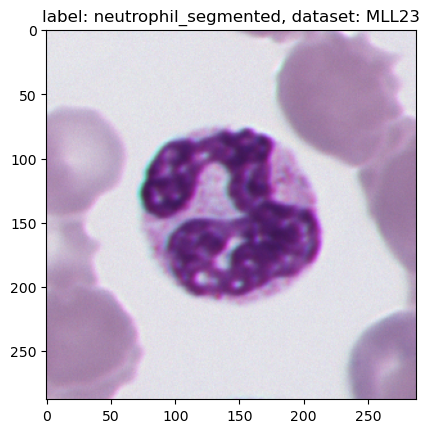

In [15]:
#show a random image from the dataset. Repeat the command to see different images.
MLL23_sample=data_sample(dataframe=MLL23_metadata)

## MLL23: Harmonisation
Next, we harmonize the MLL23 dataset's single-cell labels with two previously published public datasets.

To each label of the MLL23 dataset we assign a new harmonised label.

In [16]:
#this dictionary maps MLL23 labels to harmonised labels, where 0 means that the class will not be present in the harmonised dataset.
MLL23_labels_dict = {
    
    'basophil': 'basophil', #basophil granulocyte
    'eosinophil': 'eosinophil', #eosinophil granulocyte
    'normoblast': 'erythroblast', #normoblast/erythroblast
    'hairy_cell': 0, #hairy cell
    'lymphocyte': 'lymphocyte', #lymphocyte
    'lymphocyte_large_granular': 0, #large granular lymphocyte
    'lymphocyte_neoplastic': 0, #neoplastic lymphocyte
    'lymphocyte_reactive': 0, #reactive lymphocyte
    'monocyte': 'monocyte', #monocyte
    'metamyelocyte': 'metamyelocyte', #metamyelocyte
    'myeloblast': 'myeloblast', #myeloblast
    'myelocyte': 'myelocyte', #myelocyte
    'neutrophil_band': 'neutrophil_band', #band neutrophil granulocyte
    'neutrophil_segmented': 'neutrophil_segmented', #segmented neutrophil granulocyte
    'plasma_cell': 0, #plasma cell
    'promyelocyte': 'promyelocyte', #promyelocyte
    'promyelocyte_atypical': 0, #atypical promyelocyte
    'smudge_cell': 0, #smudge cell
}

Then again a dataframe can be created and inspected for the harmonised Version of the MLL23 dataset.

In [17]:
MLL23_harmonised_metadata = metadata_generator(MLL23_path, ds="MLL23", labels_dict=MLL23_labels_dict)
MLL23_harmonised_metadata

,image,file,label,dataset
0,basophil_0001.TIF,MLL23_dataset/basophil/basophil_0001.TIF,basophil,MLL23
1,basophil_0002.TIF,MLL23_dataset/basophil/basophil_0002.TIF,basophil,MLL23
2,basophil_0003.TIF,MLL23_dataset/basophil/basophil_0003.TIF,basophil,MLL23
3,basophil_0004.TIF,MLL23_dataset/basophil/basophil_0004.TIF,basophil,MLL23
4,basophil_0005.TIF,MLL23_dataset/basophil/basophil_0005.TIF,basophil,MLL23
...,...,...,...,...
31610,promyelocyte_0741.TIF,MLL23_dataset/promyelocyte/promyelocyte_0741.TIF,promyelocyte,MLL23
31611,promyelocyte_0742.TIF,MLL23_dataset/promyelocyte/promyelocyte_0742.TIF,promyelocyte,MLL23
31612,promyelocyte_0743.TIF,MLL23_dataset/promyelocyte/promyelocyte_0743.TIF,promyelocyte,MLL23
31613,promyelocyte_0744.TIF,MLL23_dataset/promyelocyte/promyelocyte_0744.TIF,promyelocyte,MLL23


The harmonised version of the MLL23 dataset now contains 31615 single cell images and 11 classes.

In [18]:
#show total number of images and number of images per class
data_report(MLL23_harmonised_metadata)

label 	 	 	#images

label
myeloblast              8606
neutrophil_segmented    7170
lymphocyte              5532
monocyte                2510
eosinophil              2448
erythroblast            2071
myelocyte                747
promyelocyte             745
neutrophil_band          687
basophil                 616
metamyelocyte            483
Name: count, dtype: int64
total	 	 	 	31615


Now an example single cell image out of the harmonised dataset can be viewed.

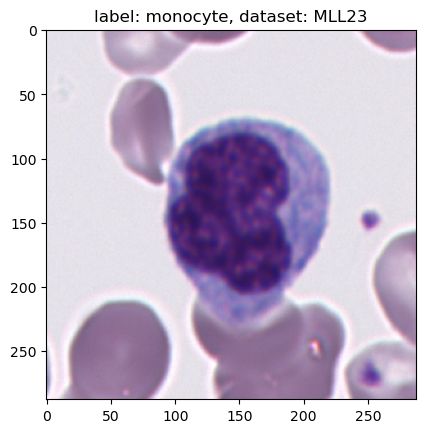

In [26]:
#show a random image from the dataset. Repeat the command to see different images.
MLL23_sample=data_sample(dataframe=MLL23_metadata)

Next, the mean values of the color channels of each image are computed and plotted.

In [27]:
#computes the mean of the red, green and blue channels for each image in the dataset and adds the values to the dataframe
MLL23_harmonised_metadata = compute_mean(MLL23_harmonised_metadata, selected_channels=[0,1,2], crop_size=None)

  0%|          | 0/31615 [00:00<?, ?it/s]

100%|██████████| 31615/31615 [01:19<00:00, 395.54it/s]


Now we can plot the data:

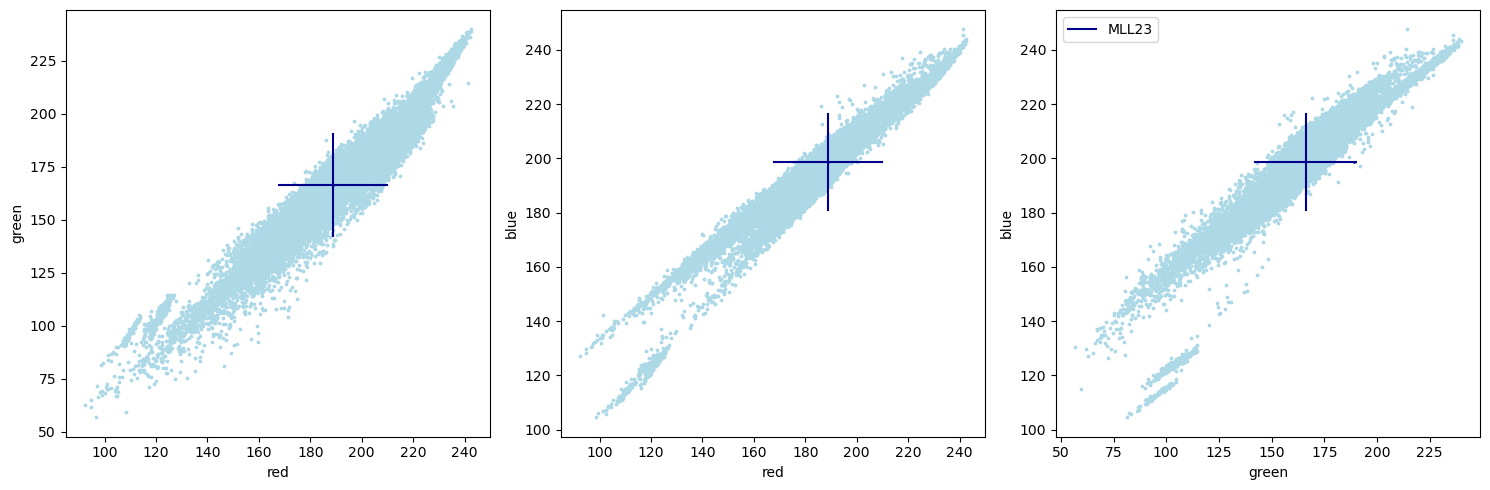

In [28]:
#plots the mean of the red, green and blue channels for each image in the dataset
MLL23_plot=data_plot([MLL23_harmonised_metadata], labels=['MLL23'])

## Matek19:
This dataset will be the first of two datasets used for comparison with the MLL23 dataset. Each single cell peripheral blood image has a size of 400x400 pixels corresponding to 29.0 x 29.0 micrometers.

The Dataset can be downloaded from:

(https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=61080958).






### Citation

The dataset was published in:
(Matek, C., Schwarz, S., Marr, C. & Spiekermann, K. A Single-cell Morphological Dataset of Leukocytes from AML Patients and Non-malignant Controls (AML-Cytomorphology_LMU). The Cancer Imaging Archive (TCIA) https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=61080958 (2019) doi:10.7937/tcia.2019.36f5o9ld.)

This dataset was also used for a study of deep learning based hematological diagnostics in:
(Matek, C., Schwarz, S., Spiekermann, K. & Marr, C. Human-level recognition of blast cells in acute myeloid leukaemia with convolutional neural networks. Nat Mach Intell 1, 538–544 (2019).)

### Description

The blood samples were taken from 100 patients suffering from acute myeloid leukemia, and 100 patients with non-neoplastic changes from the Munich University Hospital. The dataset consists of 18,365 images acquired by the M8 digital microscope, with a size of 400 x 400 pixels and 29μm x 29μm, leading to a resolution of 13.8 pixels per μm. Clinical experts annotated the images into 15 classes.

### Preparation

Again we need to specify the path to the dataset folder:

In [29]:
#set the path to the dataset
Matek19_path='Matek19_dataset'

In [30]:
#generate a dataframe containing information for each image in the Matek19 dataset
Matek19_metadata = metadata_generator(Matek19_path, ds="Matek19", labels_dict=None)
Matek19_metadata

,image,file,label,dataset
0,BAS_0001 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0001 (2021_05_21 20_42...,BAS,Matek19
1,BAS_0002 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0002 (2021_05_21 20_42...,BAS,Matek19
2,BAS_0003 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0003 (2021_05_21 20_42...,BAS,Matek19
3,BAS_0004 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0004 (2021_05_21 20_42...,BAS,Matek19
4,BAS_0005 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0005 (2021_05_21 20_42...,BAS,Matek19
...,...,...,...,...
18360,PMO_0066 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0066 (2021_05_21 20_42...,PMO,Matek19
18361,PMO_0067 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0067 (2021_05_21 20_42...,PMO,Matek19
18362,PMO_0068 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0068 (2021_05_21 20_42...,PMO,Matek19
18363,PMO_0069 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0069 (2021_05_21 20_42...,PMO,Matek19


In [31]:
data_report(Matek19_metadata)

label 	 	 	#images

label
NGS    8484
LYT    3937
MYO    3268
MON    1789
EOS     424
NGB     109
BAS      79
EBO      78
PMO      70
MYB      42
MOB      26
PMB      18
KSC      15
MMZ      15
LYA      11
Name: count, dtype: int64
total	 	 	 	18365


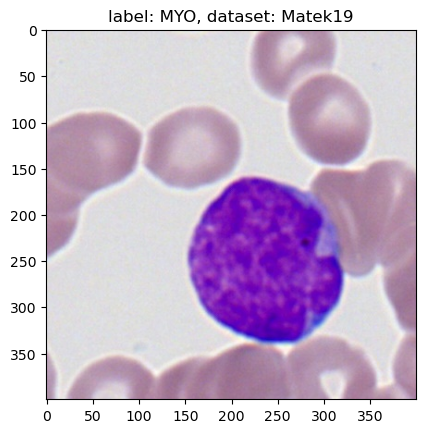

In [32]:
#show a random image from the dataset. Repeat the command to see different images.
Matek19_sample=data_sample(dataframe=Matek19_metadata)

Again the labels of the dataset have to be harmonised to enable a comparison with the MLL23 dataset.

In [34]:
#creates a dictionary mapping Matek19 labels to harmonised labels, where 0 means that the class will not be present in the harmonised dataset.
Matek19_harmonised_labels_dict = {
    'NGS': 'neutrophil_segmented', #segmented neutrophil granulocyte
    'LYT': 'lymphocyte', #lymphocyte
    'MYO': 'myeloblast', #myeloblast
    'MON': 'monocyte', #monocyte
    'EOS': 'eosinophil', #eosinophil granulocyte
    'NGB': 'neutrophil_band', #band neutrophil granulocyte
    'BAS': 'basophil', #basophil granulocyte
    'EBO': 'erythroblast', #erythroblast
    'PMO': 'promyelocyte', #promyelocyte
    'MYB': 'myelocyte', #myelocyte
    'MOB': 0, #monoblast
    'PMB': 0, #promyelocyte bilobed
    'KSC': 0, #smudge cell (Kernschatten)
    'MMZ': 'metymyelocyte', #metamyelocyte
    'LYA': 0, #lymphocyte atypical
}

In [35]:
#generate a dataframe containing information for each image in the harmonised Matek19 dataset
Matek19_harmonised_metadata = metadata_generator(Matek19_path, ds="Matek19", labels_dict=Matek19_harmonised_labels_dict)
Matek19_harmonised_metadata

,image,file,label,dataset
0,BAS_0001 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0001 (2021_05_21 20_42...,basophil,Matek19
1,BAS_0002 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0002 (2021_05_21 20_42...,basophil,Matek19
2,BAS_0003 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0003 (2021_05_21 20_42...,basophil,Matek19
3,BAS_0004 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0004 (2021_05_21 20_42...,basophil,Matek19
4,BAS_0005 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/BAS/BAS_0005 (2021_05_21 20_42...,basophil,Matek19
...,...,...,...,...
18290,PMO_0066 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0066 (2021_05_21 20_42...,promyelocyte,Matek19
18291,PMO_0067 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0067 (2021_05_21 20_42...,promyelocyte,Matek19
18292,PMO_0068 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0068 (2021_05_21 20_42...,promyelocyte,Matek19
18293,PMO_0069 (2021_05_21 20_42_39 UTC).tiff,Matek19_dataset/PMO/PMO_0069 (2021_05_21 20_42...,promyelocyte,Matek19


Then a sample image from the harmonised dataset can be viewed.

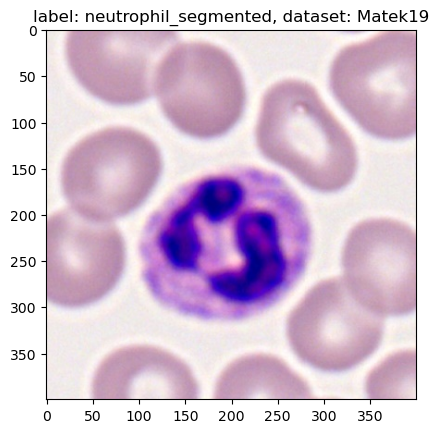

In [36]:
Matek19_sample=data_sample(dataframe=Matek19_harmonised_metadata)

Each image in the Matek19 dataset has a size of 400 x 400 pixels corresponding to 29 x 29 micrometers. To compare the Matek19 dataset with the MLL23 dataset, each image in the Matek19 dataset is cropped to a size of 345 x 345 pixels, corresponding to 25 x 25 micrometers. In this way the real life size (25 x 25 micrometers) and therefore the ratio between cells ond background is similar for both datasets.

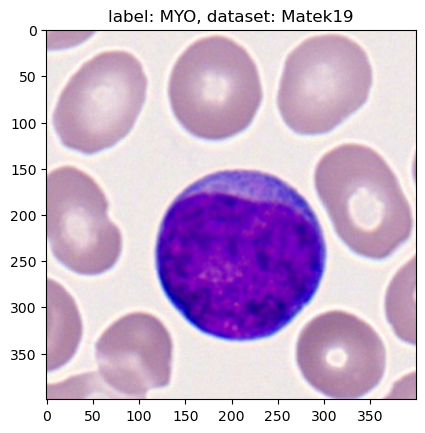

In [38]:
#show a random image from the dataset. Repeat the command to see different images.
Matek19_sample=data_sample(dataframe=Matek19_metadata)

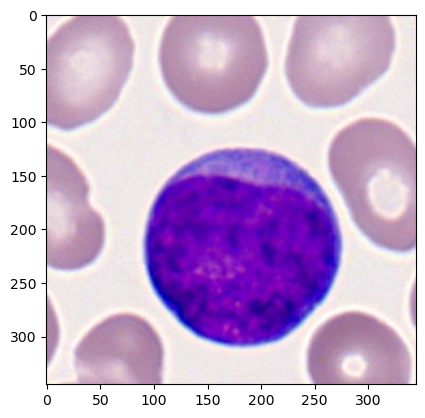

In [39]:
#crop the image
Matek19_sample_cropped=crop(Matek19_sample, crop_size=345)

Now the mean values of the color channels of the cropped images can be computed and plotted:

In [40]:
#computes the mean of the red, green and blue channels for each cropped image in the dataset and adds the values to the dataframe
Matek19_harmonised_metadata=compute_mean(Matek19_harmonised_metadata, selected_channels=[0,1,2], crop_size=345)

100%|██████████| 18295/18295 [00:47<00:00, 386.59it/s]


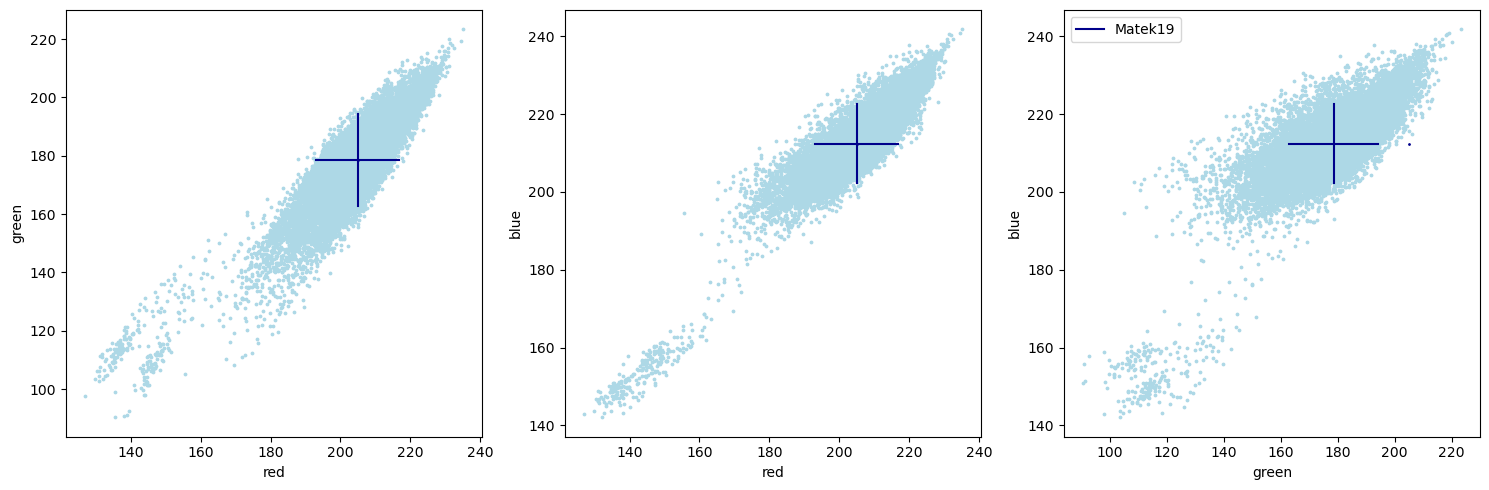

In [41]:
#plots the mean of the red, green and blue channels for each cropped image in the dataset
data_plot([Matek19_harmonised_metadata], labels=['Matek19'])

## Acevedo_20:

This is the second dataset used for comparison with the MLL23 dataset. 
Each image has a size of 360x363 pixels for 36.0 x 36.3 micrometers.

The dataset can be downloaded from:

(https://www.sciencedirect.com/science/article/pii/S2352340920303681?via%3Dihub)

### Citation

The dataset was published in:
(Acevedo, A. et al. A dataset of microscopic peripheral blood cell images for development of automatic recognition systems. Data Brief 30, 105474 (2020).)

This dataset was also used for a study of deep learning based hematological diagnostics in:
(Acevedo, A., Alférez, S., Merino, A., Puigví, L. & Rodellar, J. Recognition of peripheral blood cell images using convolutional neural networks. Comput. Methods Programs Biomed. 180, 105020 (2019).)

### Description

The blood smears were taken from individuals without an infection, hematological or oncologic disease and under no pharmacologic treatment at the Hospital Clinic of Barcelona. Images were produced with a CellaVision DM96 scanner. The dataset consists of 17,092 images with 360 x 363 pixels and 36.0μm x 36.3μm, corresponding to a resolution of 10 pixels per μm. The images were labeled into 13 different cell subtypes: Eosinophil granulocytes (3,117), platelets (2,348), segmented neutrophil granulocytes (1,646), band neutrophil granulocytes (1,633), erythroblasts (1,551), monocytes (1,420), basophil granulocytes (1,218), lymphocytes (1,214), myelocytes (1,137), metamyelocytes (1,015), promyelocytes (592), undifferentiated immature granulocytes (151), and undifferentiated segmented and band neutrophil granulocytes (50). This dataset does not include a class of atypical cells and myeloblasts. The class imbalance in this dataset is comparatively small.

Again, the path to the dataset folder has to be specified:

In [43]:
#path to the Acevedo23 dataset
Acevedo_path='Acevedo20_dataset'

Then a dataframe can be generated:

In [44]:
#generate a dataframe containing information for each image in the Acevedo23 dataset
Acevedo20_base_metadata = metadata_generator(Acevedo_path, ds="Acevedo20", labels_dict=None)
Acevedo20_base_metadata

,image,file,label,dataset
0,BA_100102.jpg,Acevedo20_dataset/basophil/BA_100102.jpg,basophil,Acevedo20
1,BA_101381.jpg,Acevedo20_dataset/basophil/BA_101381.jpg,basophil,Acevedo20
2,BA_101611.jpg,Acevedo20_dataset/basophil/BA_101611.jpg,basophil,Acevedo20
3,BA_102039.jpg,Acevedo20_dataset/basophil/BA_102039.jpg,basophil,Acevedo20
4,BA_102750.jpg,Acevedo20_dataset/basophil/BA_102750.jpg,basophil,Acevedo20
...,...,...,...,...
17087,PLATELET_997286.jpg,Acevedo20_dataset/platelet/PLATELET_997286.jpg,platelet,Acevedo20
17088,PLATELET_998559.jpg,Acevedo20_dataset/platelet/PLATELET_998559.jpg,platelet,Acevedo20
17089,PLATELET_999701.jpg,Acevedo20_dataset/platelet/PLATELET_999701.jpg,platelet,Acevedo20
17090,PLATELET_999873.jpg,Acevedo20_dataset/platelet/PLATELET_999873.jpg,platelet,Acevedo20


And the dataset can be analysed:

In [45]:
#show total number of images and number of images per class
data_report(Acevedo20_base_metadata)

label 	 	 	#images

label
neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: count, dtype: int64
total	 	 	 	17092


To harmonise the dataset some further steps are needed:

In [46]:
#dictionary mapping Acevedo20 labels to harmonised labels, where 0 means that the class will not be present in the harmonised dataset.
Acevedo20_harmonised_labels_dict = {
        'basophil': 'basophil', #basophil granulocyte
        'eosinophil': 'eosinophil', #eosinophil granulocyte
        'erythroblast': 'erythroblast', #erythroblast
        'ig': 0, #immature granulocyte, folder contains IG, MY, MMY, PMY
        'IG': 0, #unspecified immature granulocyte included in folder ig
        'PMY': 'promyelocyte', #promyelocyte, included in folder ig
        'MY': 'myelocyte', # myelocyte, included in folder ig
        'MMY': 'metamyelocyte', #metamyelocyte, included in folder ig
        'lymphocyte': 'lymphocyte', #lymphocyte
        'monocyte': 'monocyte', #monocyte
        'neutrophil': 0, #neutrophil granulocyte, folder contains NEUTROPHIL, BNE, SNE
        'NEUTROPHIL': 0, #unspecified neutrophil included in folder neutrophil
        'BNE': 'neutrophil_band', #band neutrophil granulocyte, included in folder neutrophil
        'SNE': 'neutrophil_segmented', #segmented neutrophil granulocyte, included in folder neutrophil
        'platelet': 0, #platelet
}

The folders 'ig' for immature granulocyte and 'neutrophil' for neutrophil granulocytes are containing several classes that can be distinguished by the image names. 

The folder 'ig' contains a class of unspecified immature granulocytes 'IG', the class of promyelocytes 'PMY', the class of myelocytes 'MY' and the class of metamyelocytes 'MMY'. 

The folder 'neutrophil' contains a class of unspecified neutrophil granulocytes 'NEUTROPHIL', the class of band neutrophil granulocytes 'BNE' and the class of segmented neutrophil granulocytes 'SNE'.

This script generates a new dataframe containing the subclasses and dropping for harmonisation the unspecified classes 'IG' and 'NEUTROPHIL' as well as the class of platelets:

In [47]:
Acevedo20_metadata=Acevedo20_base_metadata.copy()
for i in range(len(Acevedo20_metadata)):
    if Acevedo20_metadata['label'][i]=='ig':
        if 'MMY' in Acevedo20_metadata['image'][i]:
            Acevedo20_metadata['label'].loc[i]='metamyelocyte'
        elif 'PMY' in Acevedo20_metadata['image'][i]:
            Acevedo20_metadata['label'].loc[i]='promyelocyte'
        elif 'MY' in Acevedo20_metadata['image'][i]:
            Acevedo20_metadata['label'].loc[i]='myelocyte'
    elif Acevedo20_metadata['label'][i]=='neutrophil':
        if 'BNE' in Acevedo20_metadata['image'][i]:
            Acevedo20_metadata['label'].loc[i]='neutrophil_band'
        elif 'SNE' in Acevedo20_metadata['image'][i]:
            Acevedo20_metadata['label'].loc[i]='neutrophil_segmented'

Acevedo20_metadata=Acevedo20_metadata.loc[Acevedo20_metadata['label']!='ig'].reset_index(drop = True)
Acevedo20_metadata=Acevedo20_metadata.loc[Acevedo20_metadata['label']!='neutrophil'].reset_index(drop = True)
Acevedo20_metadata=Acevedo20_metadata.loc[Acevedo20_metadata['label']!='platelet'].reset_index(drop = True)
Acevedo20_metadata

,image,file,label,dataset
0,BA_100102.jpg,Acevedo20_dataset/basophil/BA_100102.jpg,basophil,Acevedo20
1,BA_101381.jpg,Acevedo20_dataset/basophil/BA_101381.jpg,basophil,Acevedo20
2,BA_101611.jpg,Acevedo20_dataset/basophil/BA_101611.jpg,basophil,Acevedo20
3,BA_102039.jpg,Acevedo20_dataset/basophil/BA_102039.jpg,basophil,Acevedo20
4,BA_102750.jpg,Acevedo20_dataset/basophil/BA_102750.jpg,basophil,Acevedo20
...,...,...,...,...
14538,SNE_995183.jpg,Acevedo20_dataset/neutrophil/SNE_995183.jpg,neutrophil_segmented,Acevedo20
14539,SNE_99568.jpg,Acevedo20_dataset/neutrophil/SNE_99568.jpg,neutrophil_segmented,Acevedo20
14540,SNE_995695.jpg,Acevedo20_dataset/neutrophil/SNE_995695.jpg,neutrophil_segmented,Acevedo20
14541,SNE_995874.jpg,Acevedo20_dataset/neutrophil/SNE_995874.jpg,neutrophil_segmented,Acevedo20


Now the harmonised dataframe can be analysed:

In [48]:
#shows total number of images and number of images per class
data_report(Acevedo20_metadata)

label 	 	 	#images

label
eosinophil              3117
neutrophil_segmented    1646
neutrophil_band         1633
erythroblast            1551
monocyte                1420
basophil                1218
lymphocyte              1214
myelocyte               1137
metamyelocyte           1015
promyelocyte             592
Name: count, dtype: int64
total	 	 	 	14543


In [49]:
#computes the mean of the red, green and blue channels for each image in the dataset and adds the values to the dataframe
Acevedo20_metadata=compute_mean(Acevedo20_metadata, selected_channels=[0,1,2])

100%|██████████| 14543/14543 [00:24<00:00, 596.55it/s]


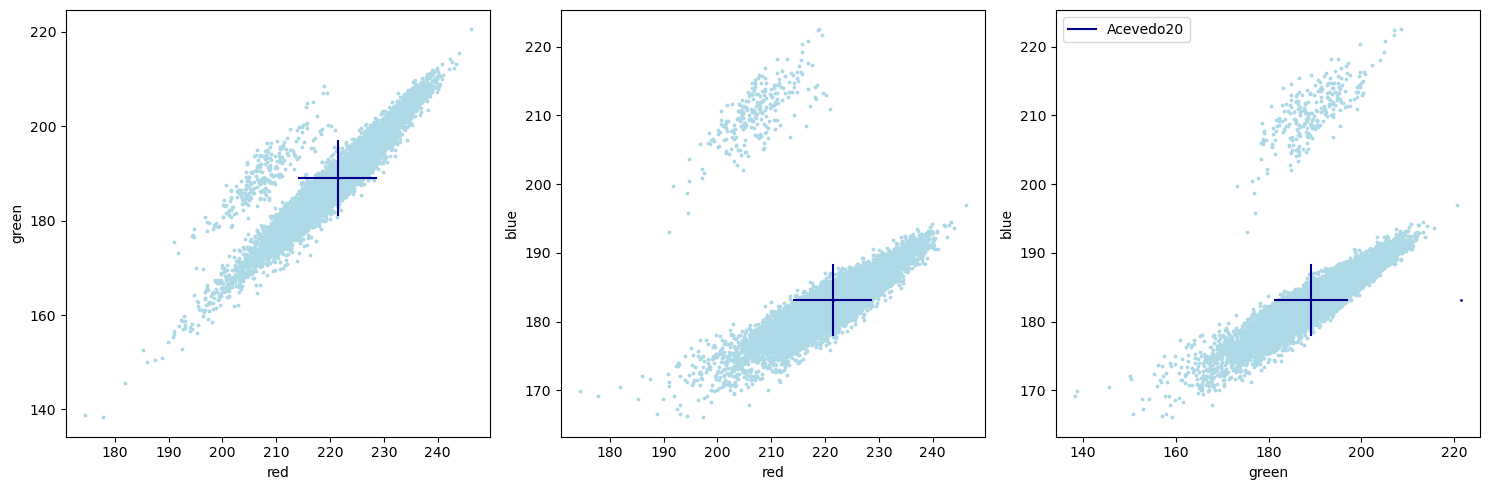

In [50]:
data_plot([Acevedo20_metadata], labels=['Acevedo20'])

The Acevedo dataset is apparently split into two different datasets. We will now separate those datasets and only work with the much larger one.


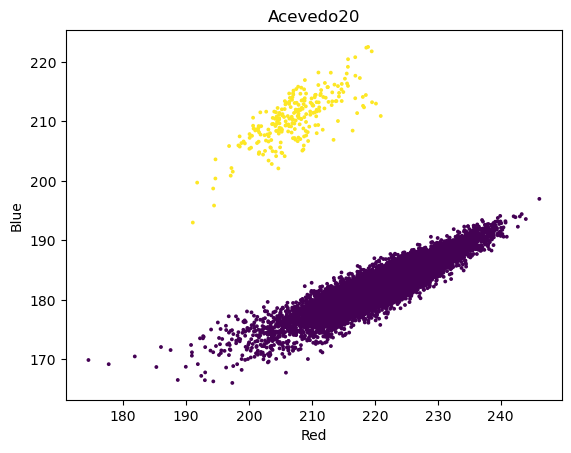

In [51]:
Acevedo20_subset1_metadata, Acevedo20_subset2_metadata=data_separation(Acevedo20_metadata, label='Acevedo20')

Clustering was used to seperate the dataset into two subsets: Acevedo20_subset1_metadata and Acevedo20_subset2_metadata. 
These can now be further analysed:

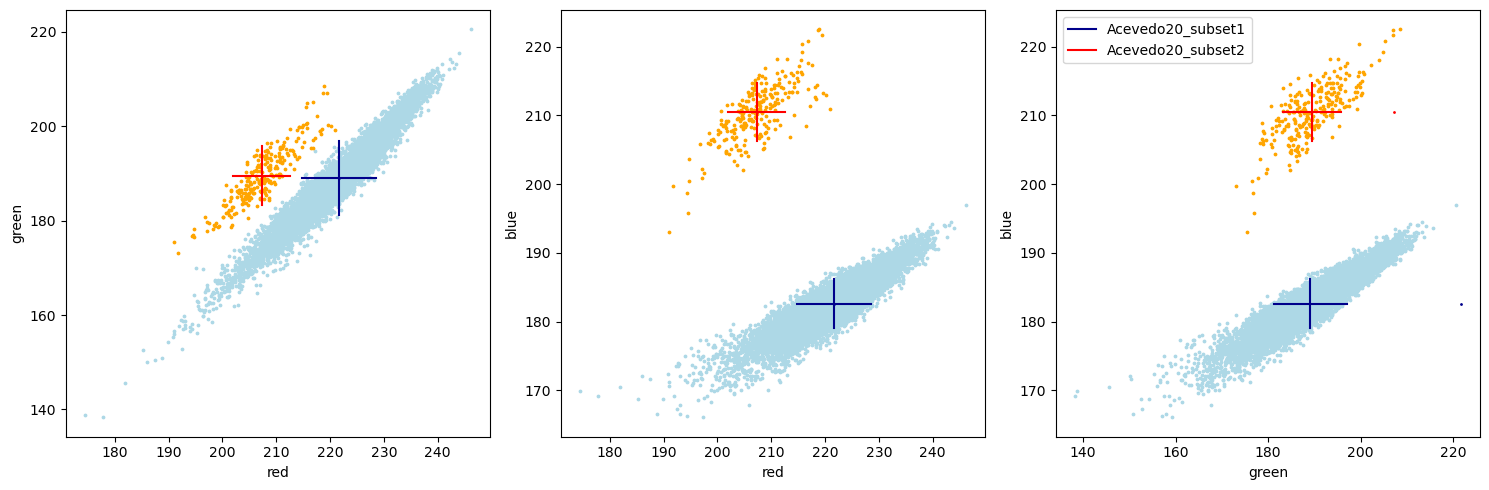

In [52]:
#plots the mean of the red, green and blue channels for each image in the 2 datasets
data_plot(dataframes=[Acevedo20_subset1_metadata, Acevedo20_subset2_metadata], labels=['Acevedo20_subset1', 'Acevedo20_subset2'])

Labels of subset1:

In [53]:
#shows total number of images and number of images per class
data_report(Acevedo20_subset1_metadata)

label 	 	 	#images

label
eosinophil              3067
neutrophil_segmented    1646
neutrophil_band         1633
erythroblast            1499
monocyte                1370
basophil                1168
lymphocyte              1164
myelocyte               1137
metamyelocyte           1015
promyelocyte             592
Name: count, dtype: int64
total	 	 	 	14291


Labels of subset2

In [54]:
#shows total number of images and number of images per class
data_report(Acevedo20_subset2_metadata)

label 	 	 	#images

label
erythroblast    52
basophil        50
eosinophil      50
lymphocyte      50
monocyte        50
Name: count, dtype: int64
total	 	 	 	252


Sample image of subset1:

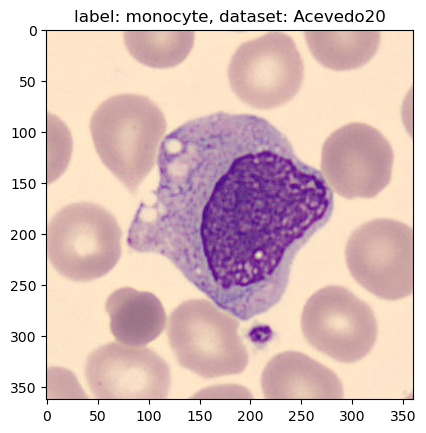

In [55]:
#show a random image from the dataset. Repeat the command to see different images.
Acevedo20_subset1_sample=data_sample(dataframe=Acevedo20_subset1_metadata)

Sample image of subset2:

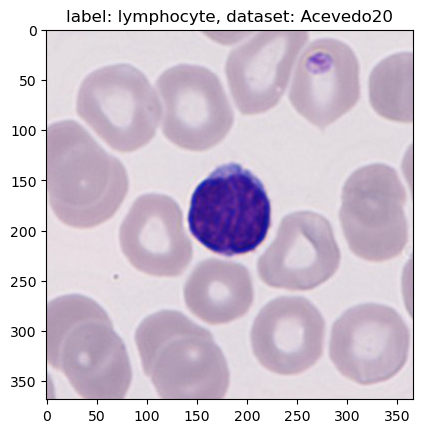

In [56]:
#show a random image from the dataset. Repeat the command to see different images.
Acevedo20_subset2_sample=data_sample(dataframe=Acevedo20_subset2_metadata)

As shown, there is a visible difference between images of the two subsets. Because subset2 only contains 252 images it is not big enough to be used as seperate dataset here. Therefore only subset1 of the Acevedo20 dataset will be used further.

Again each image needs to be cropped: Each image in the Acevedo20 subdataset1 has a size of 360 x 363 pixels for 36.0 x 36.3 micrometers. So they need to be cropped to a size of 250 x 250 pixels for 25 x 25 micrometers.

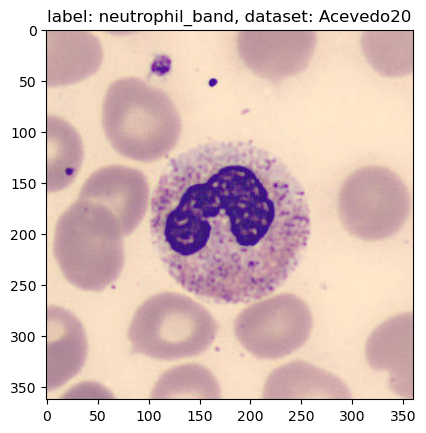

In [60]:
#show a random image from the dataset. Repeat the command to see different images.
Acevedo20_subset1_sample=data_sample(dataframe=Acevedo20_subset1_metadata)

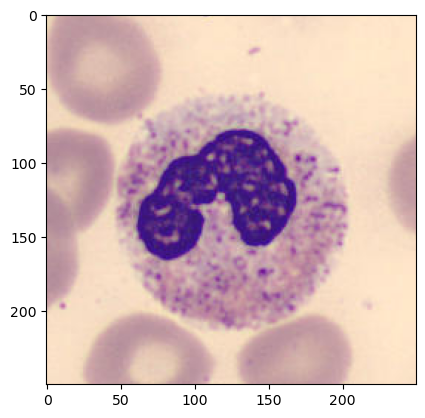

In [61]:
#crop the image
Acevedo20_subset1_sample_cropped=crop(Acevedo20_subset1_sample, crop_size=250)

Now the dataset Acevedo20_harmonised_metadata can be computed as a cropped version of the Acevedo20_subset1_metadata:

In [62]:
#create a new dataframe containing the cropped images
Acevedo20_harmonised_metadata=compute_mean(Acevedo20_subset1_metadata, selected_channels=[0,1,2], crop_size=250)

100%|██████████| 14291/14291 [00:24<00:00, 580.64it/s]


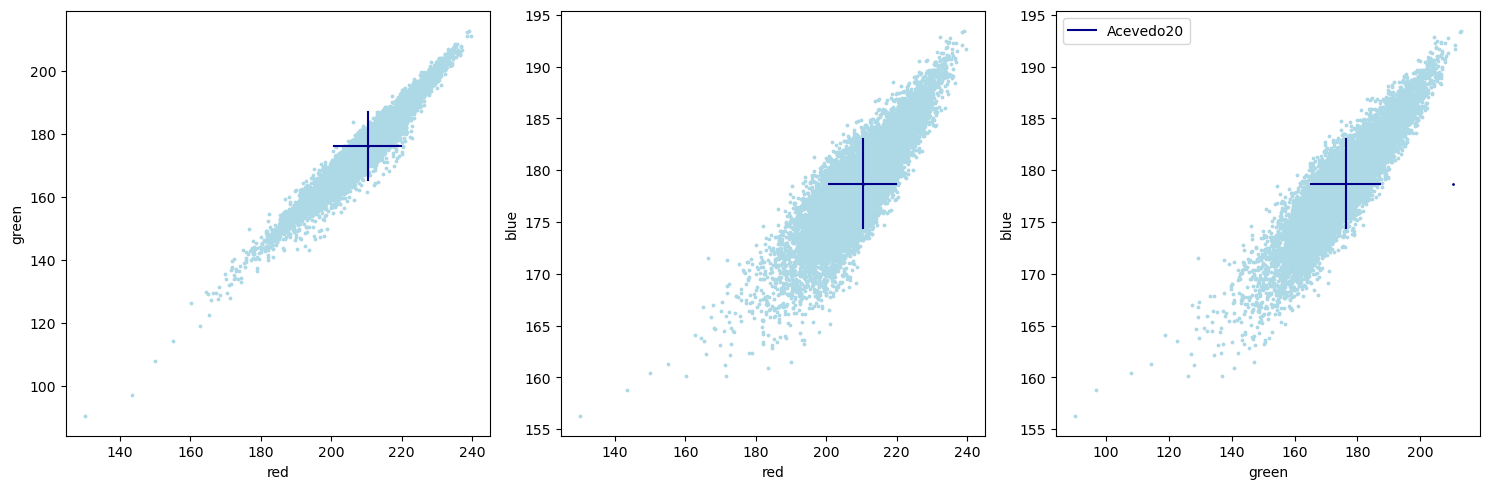

In [63]:
#plot the mean of the red, green and blue channels for each cropped image in the dataset
data_plot([Acevedo20_harmonised_metadata], labels=['Acevedo20'])

## Comparison

Finally, the three datasets MLL23, Matek19 and Acevedo20 can be plotted next to each other:

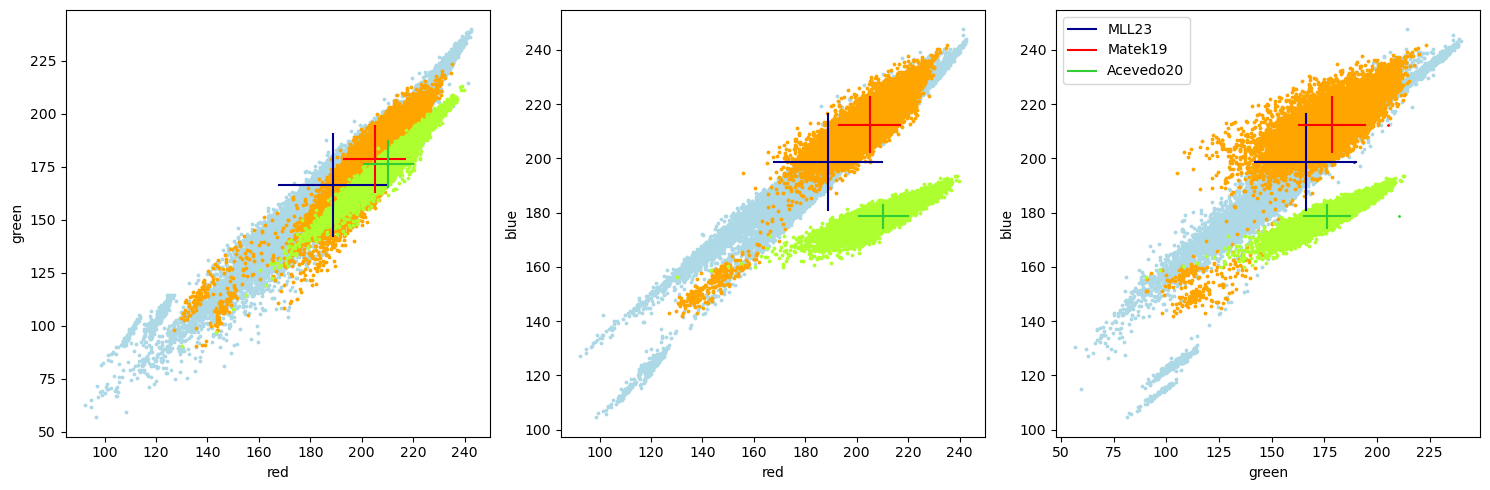

In [64]:
#plot the mean of the red, green and blue channels for each cropped image in the datasets
data_plot([MLL23_harmonised_metadata, Matek19_harmonised_metadata, Acevedo20_harmonised_metadata], labels=['MLL23', 'Matek19', 'Acevedo20'])

For domain generalization the library https://github.com/marrlab/DomainLab by X. Sun et al. can be used.